# **BITCOIN’S IDENTITY: Digital Gold or Speculative Asset?**

#### By Group 6 - MAM, LBS'26

This notebook explores whether Bitcoin behaves more like **digital gold** or a **speculative high-beta tech asset**.  
Through data cleaning, time-series transformations, rolling correlations, volatility analysis, and regression models,  
we compare Bitcoin’s behaviour with gold (XAU) and the tech index (QQQ).

The goal is to understand:
- How closely Bitcoin tracks movements in gold vs. tech  
- Whether Bitcoin behaves like a "store of value" or a "risk-on speculative asset"  
- How these relationships evolve before and after the approval of spot Bitcoin ETFs  


In [1]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import yfinance as yf
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns



## Data Pre-processing

This cell loads the raw Bloomberg data, cleans it, and prepares a unified dataset for analysis.




In [2]:
# Data pre-processing

# Load Excel file
file_path = "bloomberg.xlsx"

# Read sheets
btc_df = pd.read_excel(file_path, sheet_name="BTC")
qqq_df = pd.read_excel(file_path, sheet_name="QQQ")
xau_df = pd.read_excel(file_path, sheet_name="XAU")

# Clean columns
def clean_columns(df):
    df.columns = (
        df.columns.str.strip()
        .str.replace(r"\(.*?\)", "", regex=True)
        .str.replace("  ", " ")
        .str.replace(" ", "_")
    )
    return df

btc_df = clean_columns(btc_df)
qqq_df = clean_columns(qqq_df)
xau_df = clean_columns(xau_df)

# Convert Date to datetime
btc_df['Date'] = pd.to_datetime(btc_df['Date'])
qqq_df['Date'] = pd.to_datetime(qqq_df['Date'])
xau_df['Date'] = pd.to_datetime(xau_df['Date'])

# Select Close columns
btc_df = btc_df[['Date', '_Close']].rename(columns={'_Close': 'BTC_Close'})
qqq_df = qqq_df[['Date', 'Close']].rename(columns={'Close': 'QQQ_Close'})
xau_df = xau_df[['Date', 'Close']].rename(columns={'Close': 'XAU_Close'})

# Merge on Date (outer join to get all dates)
merged_df = btc_df.merge(qqq_df, on='Date', how='inner')\
                  .merge(xau_df, on='Date', how='inner')\
                  .sort_values('Date')

# Drop rows where any of the three Close prices are NaN
merged_df = merged_df.dropna(subset=['BTC_Close', 'QQQ_Close', 'XAU_Close']).reset_index(drop=True)



## Comparing BTC, Tech, and Gold on a Log Scale

We applied a **log transformation** and plotted BTC, QQQ, and XAU together to make their growth trends comparable over time.  
Since Bitcoin, tech stocks, and gold operate on very different price scales, a log scale allows us to see **relative percentage changes** rather than absolute price differences.


In [3]:
# Apply natural log transformation
merged_df['BTC_Log'] = np.log(merged_df['BTC_Close'])
merged_df['QQQ_Log'] = np.log(merged_df['QQQ_Close'])
merged_df['XAU_Log'] = np.log(merged_df['XAU_Close'])

# Create figure with secondary y-axis
fig = go.Figure()

# Left Y-axis: BTC
fig.add_trace(
    go.Scatter(
        x=merged_df['Date'], y=merged_df['BTC_Log'],
        mode='lines', name='BTC', line=dict(color='royalblue')
    )
)

# Right Y-axis: QQQ and XAU
fig.add_trace(
    go.Scatter(
        x=merged_df['Date'], y=merged_df['QQQ_Log'],
        mode='lines', name='QQQ', line=dict(color='orangered'),
        yaxis='y2'
    )
)

fig.add_trace(
    go.Scatter(
        x=merged_df['Date'], y=merged_df['XAU_Log'],
        mode='lines', name='XAU', line=dict(color='lightgreen'),
        yaxis='y2'
    )
)

# ------------------------------
# Add ETF approval vertical line
# ------------------------------
etf_approval_date = pd.to_datetime("2024-01-10")
fig.add_shape(
    type="line",
    xref="x",
    yref="paper",  # span full plot height without affecting y-axis
    x0=etf_approval_date,
    x1=etf_approval_date,
    y0=0,
    y1=1,
    line=dict(color="white", width=2, dash="dash")
)

# ETF label
fig.add_annotation(
    x=etf_approval_date,
    y=1,
    yref="paper",
    text="ETF Approval",
    showarrow=False,
    yshift=10,
    font=dict(color="white")
)

# Layout with double axis
fig.update_layout(
    title='BTC, QQQ, and XAU – Log-Transformed Closing Prices (Dual Axis)',
    xaxis=dict(title='Date'),
    yaxis=dict(
        title='BTC Log of Closing Price (ln USD)',
        titlefont=dict(color='royalblue'),
        tickfont=dict(color='royalblue')
    ),
    yaxis2=dict(
        title='QQQ & XAU Log Close Price (ln USD)',
        titlefont=dict(color='orangered'),
        tickfont=dict(color='orangered'),
        overlaying='y',
        side='right'
    ),
    template='plotly_dark',
    hovermode='x unified',
    legend=dict(x=0.02, y=0.98)
)

fig.show()


### **We Observe:**
- **Bitcoin** shows the steepest long-term growth and highest volatility.  
- **Tech (QQQ)** has a strong upward trend but is smoother than BTC.  
- **Gold (XAU)** grows steadily and slowly, reflecting its role as a stable store of value.  
- Visually, Bitcoin’s behavior is closer to **high-growth tech assets** than gold, hinting at a **speculative rather than “digital gold”** identity.  



## Trading Volume Comparison: BTC, Tech (QQQ), and Gold (XAU)

Trading volume is an important indicator of **market activity and liquidity**.  
By visualizing daily volumes for Bitcoin, tech stocks (QQQ), and gold (XAU) together:
- We can understand **how actively each asset is traded**  
- Compare **relative participation and investor interest** across asset classes  
- Detect periods of unusual trading activity that may correspond to major market events  

We used a **facet grid** so each asset has its own panel, which makes it easier to compare **patterns without overlapping scales**.


In [4]:

# Fetch Data
tickers = {
    "BTC": "BTC-USD",
    "QQQ": "QQQ",
    "XAU": "GC=F"
}

dfs = {}
for name, ticker in tickers.items():
    t = yf.Ticker(ticker)
    df = t.history(period="max").reset_index()
    df["Date"] = pd.to_datetime(df["Date"]).dt.tz_localize(None)  # timezone-naive
    dfs[name] = df

# Filter & rename
start_date = pd.Timestamp("2014-09-17")
btc_df = dfs["BTC"][dfs["BTC"]["Date"] >= start_date][["Date", "Close", "Volume"]].rename(columns={"Close":"BTC_Close","Volume":"BTC_Vol"})
qqq_df = dfs["QQQ"][dfs["QQQ"]["Date"] >= start_date][["Date", "Close", "Volume"]].rename(columns={"Close":"QQQ_Close","Volume":"QQQ_Vol"})
xau_df = dfs["XAU"][dfs["XAU"]["Date"] >= start_date][["Date", "Close", "Volume"]].rename(columns={"Close":"XAU_Close","Volume":"XAU_Vol"})

# Merge DataFrames
merged = (
    btc_df.merge(qqq_df, on="Date", how="inner")
          .merge(xau_df, on="Date", how="inner")
          .sort_values("Date")
          .dropna(subset=["BTC_Close","QQQ_Close","XAU_Close"])
          .reset_index(drop=True)
)

# Log prices
merged["BTC_Log"] = np.log(merged["BTC_Close"])
merged["QQQ_Log"] = np.log(merged["QQQ_Close"])
merged["XAU_Log"] = np.log(merged["XAU_Close"])

# Ensure numeric volume
for vcol in ["BTC_Vol","QQQ_Vol","XAU_Vol"]:
    merged[vcol] = pd.to_numeric(merged[vcol], errors="coerce").fillna(0)

# Colors
BTC_COLOR = "dodgerblue"
QQQ_COLOR = "tomato"
XAU_COLOR = "lightgreen"


# VOLUME FACET GRID

# Helper for bars
def add_bar(fig, y, title, color, row):
    fig.add_trace(go.Bar(
        x=merged["Date"],
        y=y,
        name=title,
        marker=dict(
            color=color,
            opacity=0.85,
            line=dict(color="white", width=0.4)
        ),
        showlegend=False
    ), row=row, col=1)

fig_vol = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.33, 0.33, 0.33],
    subplot_titles=[
        "BTC Volume",
        "QQQ Volume",
        "Gold (XAU) Volume"
    ]
)

# BTC Volume
add_bar(fig_vol, merged["BTC_Vol"], "BTC Volume", BTC_COLOR, row=1)

# QQQ Volume
add_bar(fig_vol, merged["QQQ_Vol"], "QQQ Volume", QQQ_COLOR, row=2)

# Gold Volume — scaled for visibility
xau_vol = merged["XAU_Vol"]
xau_99 = xau_vol.quantile(0.99)

add_bar(fig_vol, xau_vol, "Gold (XAU) Volume", XAU_COLOR, row=3)
fig_vol.update_yaxes(range=[0, float(xau_99)], row=3, col=1)

# --- Compute average volumes ---
btc_avg_vol = merged["BTC_Vol"].mean()
qqq_avg_vol = merged["QQQ_Vol"].mean()
xau_avg_vol = merged["XAU_Vol"].mean()

# Add horizontal average lines
fig_vol.add_hline(y=btc_avg_vol, line_color="white", line_dash="dot", row=1, col=1)
fig_vol.add_hline(y=qqq_avg_vol, line_color="white", line_dash="dot", row=2, col=1)
fig_vol.add_hline(y=xau_avg_vol, line_color="white", line_dash="dot", row=3, col=1)

# Add annotations for average values (TOP-LEFT CORNER)

# BTC panel
fig_vol.add_annotation(
    x=0.01,                         # left side of panel
    y=max(merged["BTC_Vol"]) * 0.95, # high position for visibility
    xref="x domain",
    yref="y",
    text=f"Avg BTC Vol: {btc_avg_vol:,.0f}",
    showarrow=False,
    font=dict(color="white", size=12),
    xanchor="left",
    yanchor="top"
)

# QQQ panel
fig_vol.add_annotation(
    x=0.01,
    y=max(merged["QQQ_Vol"]) * 0.95,
    xref="x2 domain",
    yref="y2",
    text=f"Avg QQQ Vol: {qqq_avg_vol:,.0f}",
    showarrow=False,
    font=dict(color="white", size=12),
    xanchor="left",
    yanchor="top"
)

# XAU panel
fig_vol.add_annotation(
    x=0.01,
    y=float(xau_99) * 0.95,   # use scaled max (since XAU is zoomed)
    xref="x3 domain",
    yref="y3",
    text=f"Avg XAU Vol: {xau_avg_vol:,.0f}",
    showarrow=False,
    font=dict(color="white", size=12),
    xanchor="left",
    yanchor="top"
)

# Layout
fig_vol.update_layout(
    title="Facet Grid: BTC, QQQ, and Gold (XAU) Volume",
    template="plotly_dark",
    height=900,
    hovermode="x unified",
    margin=dict(t=80, b=60, l=60, r=40),
)

# Axis labels
fig_vol.update_yaxes(title_text="BTC Volume", row=1, col=1, color=BTC_COLOR)
fig_vol.update_yaxes(title_text="QQQ Volume", row=2, col=1, color=QQQ_COLOR)
fig_vol.update_yaxes(title_text="XAU Volume", row=3, col=1, color=XAU_COLOR)
fig_vol.update_xaxes(title_text="Date", row=3, col=1)

fig_vol.show()


## Observations from Trading Volume Analysis

- **Bitcoin (BTC)**  
  - Highly volatile and speculative  
  - Extreme spikes during major market rallies or crashes  
  - **Average trading volume:** ~$22bn traded  

- **Tech (QQQ)**  
  - Stable and mature market with consistent liquidity  
  - Predictable peaks driven by macro events and earnings  
  - **Average trading volume:** ~42 million shares traded  

- **Gold (XAU)**  
  - Thin and structured market  
  - Spikes largely driven by futures contract rollovers rather than daily price movements  
  - Volume data is limited, making interpretation less precise  

**Conclusion:** BTC behaves more like a high-risk speculative asset, while QQQ represents a mature, liquid market, and Gold remains a low-volume, structured store of value.


## BTC vs Tech (QQQ) Volume Correlation

We wanted to examine whether **Bitcoin trading activity is aligned with the broader tech market**, especially around major events like the ETF approval.  
- Calculating **log changes in daily volume** allows us to standardize the spikes and account for exponential growth in BTC trading.  
- Rolling correlation shows the **dynamic relationship over time**, rather than a single static value.  


In [5]:
# 1. Compute log volume changes

merged["BTC_Vol_Change"] = np.log(merged["BTC_Vol"] / merged["BTC_Vol"].shift(1))
merged["QQQ_Vol_Change"] = np.log(merged["QQQ_Vol"] / merged["QQQ_Vol"].shift(1))

merged = merged.replace([np.inf, -np.inf], np.nan)
merged = merged.dropna(subset=["BTC_Vol_Change", "QQQ_Vol_Change"]).copy()

# 2. Rolling correlation

window = 30
merged["vol_corr"] = merged["BTC_Vol_Change"].rolling(window).corr(merged["QQQ_Vol_Change"])

# 3. Compute Pre-ETF and Post-ETF averages

start_pre = pd.to_datetime("2024-01-01")
end_pre = pd.to_datetime("2024-01-10")
cutoff_date = pd.to_datetime("2024-01-10")

pre_etf = merged[(merged["Date"] >= start_pre) & (merged["Date"] < end_pre)]
post_etf = merged[merged["Date"] >= cutoff_date]

avg_corr_pre_etf = pre_etf["vol_corr"].mean()
avg_corr_post_etf = post_etf["vol_corr"].mean()

print("Pre-ETF (2018-2024) Avg Corr:", avg_corr_pre_etf)
print("Average BTC–QQQ Volume Correlation AFTER Jan 10, 2024:", avg_corr_post_etf)


# 4. Plot

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=merged["Date"],
    y=merged["vol_corr"],
    mode="lines",
    name=f"{window}-Day Rolling Volume Correlation",
    line=dict(color="cyan", width=2)
))

# Zero line
fig.add_shape(
    type="line",
    x0=merged["Date"].min(),
    x1=merged["Date"].max(),
    y0=0, y1=0,
    line=dict(color="grey", width=1, dash="dot")
)

# ETF approval vertical red line (does not disturb y-axis)
etf_approval_date = pd.to_datetime("2024-01-10")
fig.add_shape(
    type="line",
    xref="x",
    yref="paper",
    x0=etf_approval_date,
    x1=etf_approval_date,
    y0=0,
    y1=1,
    line=dict(color="white", width=2, dash="dash")
)

# ETF annotation
fig.add_annotation(
    x=etf_approval_date,
    y=1,
    yref="paper",
    text="ETF Approval",
    showarrow=False,
    yshift=10,
    font=dict(color="white")
)

# Average correlation annotations
fig.add_annotation(
    x=merged["Date"].min(),
    y=0.75,
    text=f"Pre-ETF (2018-2024) Avg Corr: {avg_corr_pre_etf:.3f}",
    showarrow=False,
    font=dict(color="white", size=12),
    xanchor="left"
)

fig.add_annotation(
    x=merged["Date"].min(),
    y=0.65,
    text=f"Post-ETF Avg Corr: {avg_corr_post_etf:.3f}",
    showarrow=False,
    font=dict(color="white", size=12),
    xanchor="left"
)

fig.update_layout(
    title=f"{window}-Day Rolling Pearson Correlation Between BTC and QQQ Volume",
    template="plotly_dark",
    hovermode="x unified",
    height=500,
    xaxis_title="Date",
    yaxis_title="Correlation"
)

fig.show()


Pre-ETF (2018-2024) Avg Corr: -0.010026345835512604
Average BTC–QQQ Volume Correlation AFTER Jan 10, 2024: 0.29768464770191116



### Observation: BTC vs Tech Volume Correlation Post-ETF

After the ETF approval, Bitcoin’s trading volume correlation with tech stocks (QQQ) stabilized around **0.5**, indicating a consistent positive relationship.  


## 📈 Rolling Volatility Analysis

We aim to examine the **risk and price fluctuations** of Bitcoin, Gold, and Tech stocks over time.  
- By splitting the dataset **pre- and post-ETF approval**, we can identify any shifts in market dynamics around this major event.  
- **Rolling volatility** measures the **standard deviation of daily returns** over a 30-day window, providing a smoothed view of short-term price fluctuations.


In [6]:

# Define ETF approval date
etf_approval_date = pd.to_datetime('2024-01-10')

# Split pre- and post-ETF
pre_df = merged_df[merged_df['Date'] < etf_approval_date]
post_df = merged_df[merged_df['Date'] >= etf_approval_date]

# Correlations
print("Pre-ETF correlations:")
print(pre_df[['BTC_Close', 'XAU_Close', 'QQQ_Close']].corr())

print("\nPost-ETF correlations:")
print(post_df[['BTC_Close', 'XAU_Close', 'QQQ_Close']].corr())

# Compute rolling volatility
window = 30  # 30-day rolling window
for col in ['BTC_Close', 'XAU_Close', 'QQQ_Close']:
    merged_df[f'{col}_Vol'] = merged_df[col].pct_change().rolling(window).std()

# Plot rolling volatility
fig = go.Figure()

fig.add_trace(go.Scatter(x=merged_df['Date'], y=merged_df['BTC_Close_Vol'], mode='lines', name='BTC Volatility'))
fig.add_trace(go.Scatter(x=merged_df['Date'], y=merged_df['XAU_Close_Vol'], mode='lines', name='Gold Volatility'))
fig.add_trace(go.Scatter(x=merged_df['Date'], y=merged_df['QQQ_Close_Vol'], mode='lines', name='Tech Volatility'))

# Add vertical line for ETF approval
fig.add_shape(
    type='line',
    x0=etf_approval_date, x1=etf_approval_date,
    y0=0, y1=merged_df[['BTC_Close_Vol', 'XAU_Close_Vol', 'QQQ_Close_Vol']].max().max(),
    line=dict(color='white', width=2, dash='dash'),
)

# Add dummy scatter trace for legend
fig.add_trace(go.Scatter(
    x=[etf_approval_date],
    y=[None],
    mode='lines',
    line=dict(color='white', dash='dash'),
    name='ETF Approval'
))

# Layout
fig.update_layout(
    title=f'{window}-Day Rolling Volatility',
    xaxis_title='Date',
    yaxis_title='Volatility (Std. Dev. of Returns)',
    template='plotly_dark',
    hovermode='x unified'
)

fig.show()


Pre-ETF correlations:
           BTC_Close  XAU_Close  QQQ_Close
BTC_Close   1.000000   0.699929   0.904654
XAU_Close   0.699929   1.000000   0.735359
QQQ_Close   0.904654   0.735359   1.000000

Post-ETF correlations:
           BTC_Close  XAU_Close  QQQ_Close
BTC_Close   1.000000   0.856260   0.863941
XAU_Close   0.856260   1.000000   0.855365
QQQ_Close   0.863941   0.855365   1.000000


### Observation:

1. **Consistently high risk:** Bitcoin’s volatility has historically been **much higher** than QQQ or Gold, reflecting its speculative nature.  
2. **Post-ETF moderation:** After the ETF approval, BTC volatility **declined slightly** but still remains **significantly above** the other two assets.  
3. **Converging trend:** The pattern suggests that BTC volatility may **gradually converge toward QQQ volatility** over time, indicating increasing market maturity and potentially reduced speculative swings.



### Rolling Correlations Between Bitcoin, Tech, and Gold

This step examines how Bitcoin's returns move relative to tech stocks (QQQ) and gold over time, using **90-day rolling correlations**. We overlay significant macro events and the ETF approval to see how external shocks affect these relationships.


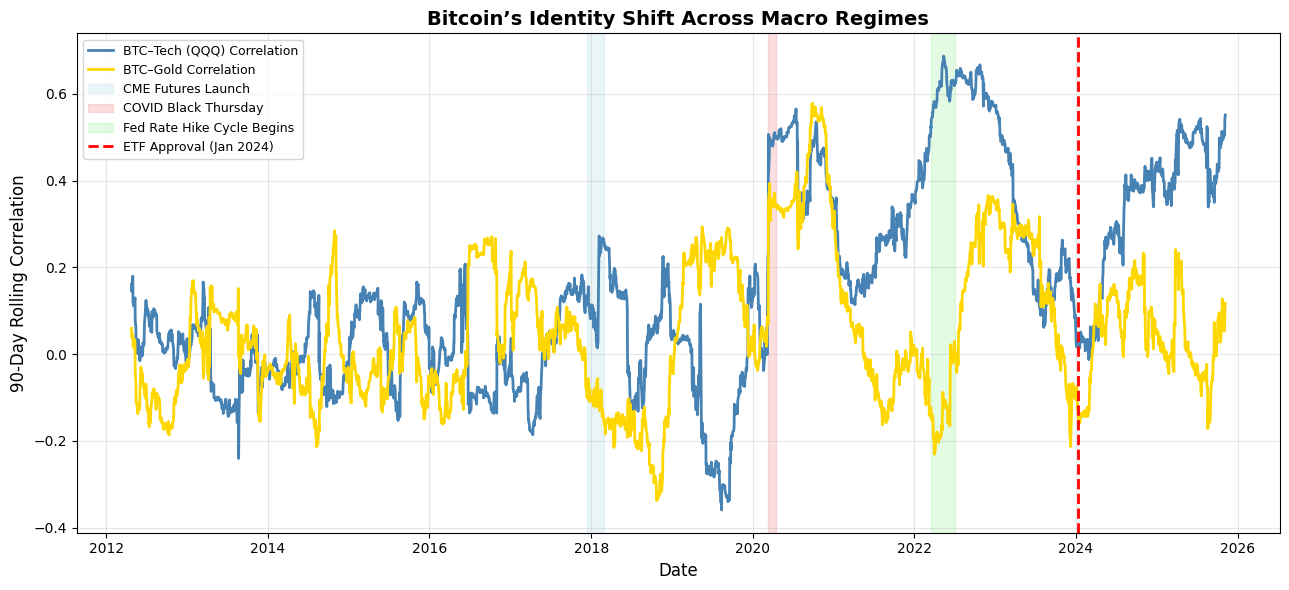

In [7]:

df = merged_df.copy()
# Step 4: Compute daily log returns
df["r_BTC"] = np.log(df["BTC_Close"] / df["BTC_Close"].shift(1))
df["r_QQQ"] = np.log(df["QQQ_Close"] / df["QQQ_Close"].shift(1))
df["r_XAU"] = np.log(df["XAU_Close"] / df["XAU_Close"].shift(1))

# Step 5: Calculate rolling 90-day correlations
window = 90
df["corr_BTC_QQQ"] = df["r_BTC"].rolling(window).corr(df["r_QQQ"])
df["corr_BTC_XAU"] = df["r_BTC"].rolling(window).corr(df["r_XAU"])

# Step 7: Define macro events (excluding ETF approval)
macro_events = [
    {"start": "2017-12-11", "end": "2018-03-01", "color": "lightblue", "label": "CME Futures Launch"},
    {"start": "2020-03-12", "end": "2020-04-15", "color": "lightcoral", "label": "COVID Black Thursday"},
    {"start": "2022-03-16", "end": "2022-07-01", "color": "lightgreen", "label": "Fed Rate Hike Cycle Begins"},
]

# Step 8: Plot correlations with macro events and ETF line
plt.figure(figsize=(13,6))

# Plot rolling correlations
plt.plot(df["Date"], df["corr_BTC_QQQ"], color="steelblue", label="BTC–Tech (QQQ) Correlation", linewidth=2)
plt.plot(df["Date"], df["corr_BTC_XAU"], color="gold", label="BTC–Gold Correlation", linewidth=2)

# Add shaded macro event areas
for ev in macro_events:
    plt.axvspan(pd.Timestamp(ev["start"]), pd.Timestamp(ev["end"]),
                color=ev["color"], alpha=0.25, label=ev["label"])

# Add the ETF approval as a simple red dashed line (no label text)
etf_date = pd.Timestamp("2024-01-10")
plt.axvline(etf_date, color="red", linestyle="--", linewidth=2,label="ETF Approval (Jan 2024)")

plt.title("Bitcoin’s Identity Shift Across Macro Regimes", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("90-Day Rolling Correlation", fontsize=12)
plt.legend(loc="upper left", fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




### Interpretation of Rolling Correlations

**Observations:**  
1. **Bitcoin increasingly moves with tech equities (QQQ):** The 90-day rolling correlations show a growing alignment between BTC and QQQ over time.  
2. **Correlation spikes at major events:** Noticeable increases in BTC-QQQ correlation occur around key market events such as the CME Futures Launch (2017), COVID crash (2020), the start of the Fed rate hike cycle (2022), and ETF approval (2024).  
3. **Bitcoin-Gold correlation remains low:** BTC shows minimal alignment with gold, indicating it does not act as a traditional safe-haven asset.  
4. **Bitcoin behaves as a risk-on asset:** The higher correlation with tech suggests BTC is sensitive to market liquidity and macroeconomic policy shifts, rather than providing protection during market stress.


### Pre- and Post-ETF Price Correlations

We split the data around the ETF approval date to observe how the relationships between Bitcoin (BTC), tech equities (QQQ), and gold (XAU) evolved before and after the market became more accessible to institutional investors.


Pre-ETF Correlation Matrix:


,BTC,QQQ,XAU
BTC,1.0000,0.9267,0.7978
QQQ,0.9267,1.0000,0.8100
XAU,0.7978,0.8100,1.0000



Post-ETF Correlation Matrix:


,BTC,QQQ,XAU
BTC,1.0000,0.7594,0.6451
QQQ,0.7594,1.0000,0.6931
XAU,0.6451,0.6931,1.0000


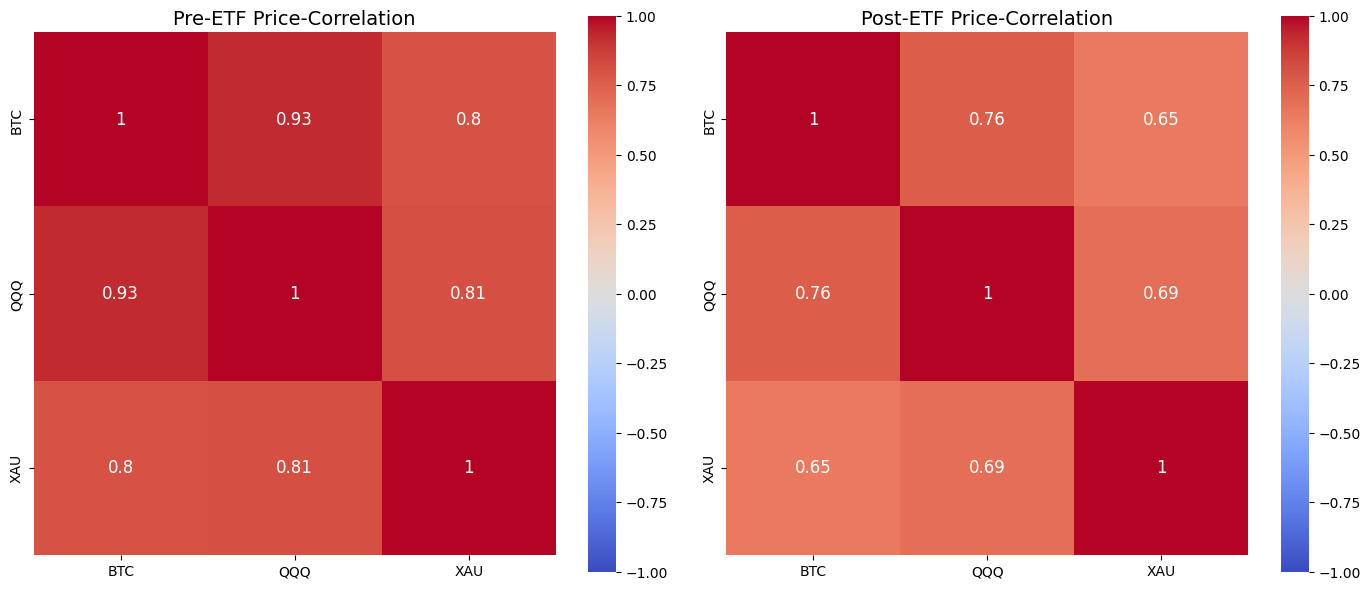

In [8]:

# Define ETF approval date
etf_date = pd.to_datetime('2024-10-01')

# Split pre- and post-ETF data
pre_df = merged_df[merged_df['Date'] < etf_date]
post_df = merged_df[merged_df['Date'] >= etf_date]

# Select and rename columns for cleaner correlation labels
cols = {
    'BTC_Close': 'BTC',
    'QQQ_Close': 'QQQ',
    'XAU_Close': 'XAU'
}

pre_corr_df = pre_df[list(cols.keys())].rename(columns=cols)
post_corr_df = post_df[list(cols.keys())].rename(columns=cols)

# Compute correlation matrices
corr_pre = pre_corr_df.corr()
corr_post = post_corr_df.corr()

# Display summary tables
print("Pre-ETF Correlation Matrix:")
display(corr_pre.round(4))

print("\nPost-ETF Correlation Matrix:")
display(corr_post.round(4))

# Heatmap visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(corr_pre, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            square=True, ax=axes[0], annot_kws={"size": 12})
axes[0].set_title('Pre-ETF Price-Correlation', fontsize=14)

sns.heatmap(corr_post, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            square=True, ax=axes[1], annot_kws={"size": 12})
axes[1].set_title('Post-ETF Price-Correlation', fontsize=14)

plt.tight_layout()
plt.show()

**Observations from the correlation matrices and heatmaps:**  
1. **Pre-ETF correlations:**  
   - BTC was strongly correlated with QQQ (0.927) and moderately with gold (0.798).  
   - This suggests that even before institutional involvement, BTC shared price movements with tech equities and had some alignment with gold.  

2. **Post-ETF correlations:**  
   - BTC-QQQ correlation dropped to 0.759, and BTC-Gold dropped to 0.645.  
   - Although correlations decreased, BTC still shows higher alignment with tech equities than with gold.  
   - The drop is likely due to the shorter post-ETF sample (≈2 years) compared to the longer pre-ETF period (≈12 years), as well as new market dynamics introduced by the ETF.  

**Conclusion:**  
Post-ETF, BTC maintains a stronger relationship with tech equities than with gold, indicating it behaves more like a risk-on asset than a traditional safe-haven. The heatmaps visually reinforce this trend, showing a relative decrease in correlation intensity after the ETF approval.

```markdown
### Regression Analysis: BTC vs Gold (XAU) and Tech (QQQ)

We perform linear regressions to quantify how closely Bitcoin's price moves with gold and tech equities. This helps us understand whether BTC behaves more like a traditional safe-haven (gold) or a risk-on asset (tech).


In [9]:

def run_regression(X_col, y_col, df):
    X = df[[X_col]]
    y = df[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f"Regression BTC vs {X_col}:")
    print(f"R^2: {r2_score(y_test, y_pred):.4f}, MSE: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"Coefficient: {lr.coef_[0]:.4f}, Intercept: {lr.intercept_:.4f}\n")
    return lr

lr_xau = run_regression('XAU_Close', 'BTC_Close', merged_df)
lr_qqq = run_regression('QQQ_Close', 'BTC_Close', merged_df)


Regression BTC vs XAU_Close:
R^2: 0.8288, MSE: 152538708.6198
Coefficient: 48.7286, Intercept: -60537.3633

Regression BTC vs QQQ_Close:
R^2: 0.8787, MSE: 108065662.1819
Coefficient: 190.4651, Intercept: -22288.4199



In [10]:
# plotting the graph
# BTC vs Gold
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=merged_df['XAU_Close'], y=merged_df['BTC_Close'], mode='markers', name='Data'))
fig1.add_trace(go.Scatter(x=merged_df['XAU_Close'], y=lr_xau.predict(merged_df[['XAU_Close']]), mode='lines', name='Regression Line'))
fig1.update_layout(title='BTC vs Gold Regression', xaxis_title='Gold Close', yaxis_title='BTC Close', template='plotly_dark')
fig1.show()

# BTC vs Tech
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=merged_df['QQQ_Close'], y=merged_df['BTC_Close'], mode='markers', name='Data'))
fig2.add_trace(go.Scatter(x=merged_df['QQQ_Close'], y=lr_qqq.predict(merged_df[['QQQ_Close']]), mode='lines', name='Regression Line'))
fig2.update_layout(title='BTC vs Tech Regression', xaxis_title='Tech Index Close', yaxis_title='BTC Close', template='plotly_dark')
fig2.show()


**Results:**  
1. **BTC vs Gold (XAU):**  
   - R² = 0.829 → ~83% of BTC's price variation can be explained by gold.  
   - Coefficient = 48.73 → For every $1 change in gold, BTC changes by ~$48.7 on average.  
   - MSE is relatively high, indicating large deviations in absolute price values.

2. **BTC vs Tech (QQQ):**  
   - R² = 0.879 → ~88% of BTC's price variation is explained by tech equities.  
   - Coefficient = 190.47 → BTC price reacts strongly to tech price changes.  
   - Lower MSE than BTC-Gold regression, suggesting a better fit.

**Interpretation:**  
- Bitcoin's price has a stronger linear relationship with tech equities than with gold.  
- This reinforces the idea that BTC behaves more like a risk-on macro asset rather than a safe-haven asset, responding to liquidity, market sentiment, and tech sector movements.

### Conclusion: Bitcoin's Identity

Based on our analysis of price, volume, volatility, correlations, and regression results:

1. **Speculative and High-Volatility Asset:**  
   BTC exhibits extreme price and volume fluctuations compared to mature assets like tech equities (QQQ) and gold (XAU), highlighting its speculative nature.

2. **Correlation Patterns:**  
   - BTC correlates strongly with tech stocks, especially around major macro events (CME launch, COVID crash, Fed rate hikes) and post-ETF approval.  
   - Correlation with gold remains low, indicating BTC does not behave like a traditional safe-haven.

3. **Market Behavior Post-ETF:**  
   Trading volume correlations with tech equities became more stable after ETF approval, suggesting BTC and tech attract similar institutional flows and move as part of broader risk-on liquidity cycles.

4. **Regression Insights:**  
   BTC price is more sensitive to tech stock movements than gold, reinforcing the view that BTC behaves like a macro-driven, risk-on asset rather than “digital gold.”

**Overall Insight:**  
Bitcoin's identity aligns more closely with a **speculative, risk-on macro asset** rather than a safe-haven or “digital gold.” Its behavior is heavily influenced by liquidity, market sentiment, and institutional participation, making it a unique component in modern portfolios.

